# **Projet 6 : Analyser les ventes d'une librairie avec R ou Python**

# **I. Importations des librairies**

In [1]:
#Importation des librairies
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels
import time
import scipy.stats as st
import statsmodels.formula.api
import statsmodels.api

# **II. Chargement et préparation des données**

In [2]:
#Chargement des fichiers csv
customers = pd.read_csv("customers.csv", sep=",")
products = pd.read_csv("products.csv", sep=",")
transactions = pd.read_csv("transactions.csv", sep=",")
#Test d'unicité
#False = nombres de lignes non dupliquées
def unicity_check(df, col):
    temp = df.duplicated(subset=col, keep=False)
    temp = temp.value_counts()
    return(temp)
#Défini une fonction servant à calculer les moyennes mobiles avec une fenêtre de 3
def moy_mob(df):
    lendf=len(df)
    moys=[]
    moys.append(df.iloc[0])
    for i in range(1,(lendf-1)):
        moymob=(df.iloc[i-1]+df.iloc[i]+df.iloc[i+1])/3
        moys.append(moymob)
    moys.append(df.iloc[lendf-1])
    return(moys)
#Ajustements
#Calcule la date d'aujourdui et la converti en datetime
today = str(time.localtime().tm_year) + "-" + str(time.localtime().tm_mon) + "-" + str(time.localtime().tm_mday) + " " + str(time.localtime().tm_hour) + ":" + str(time.localtime().tm_min) + ":" + str(time.localtime().tm_sec) + ".000000"
today = pd.to_datetime(today)
#Dataset qui contient les lignes de test
test_transac = transactions.loc[transactions["id_prod"]=="T_0"]
#Affiche les différentes valeurs de id_prod dans test ainsi que leurs nombre d'occurences
print(test_transac["id_prod"].value_counts())
#Drop les colonnes test
transactions = transactions.drop(transactions[transactions.id_prod=="T_0"].index)
#converti la colonne date en datetime
transactions["date"]=pd.to_datetime(transactions["date"])
#Vérifications des types de colonnes
print("customers")
print()
print(customers.dtypes)
print()
print("products")
print(products.dtypes)
print()
print("transactions")
print(transactions.dtypes)
#test d'unicité
print()
print("Test d'unicité sur transactions/session_id")
print()
print(unicity_check(transactions, ["session_id"]))
print()
print("Test d'unicité sur transactions/date")
print()
print(unicity_check(transactions, ["date"]))
print()
print("Test d'unicité sur customers/client_id")
print()
print(unicity_check(customers, ["client_id"]))
print()
print("Test d'unicité sur products/id_prod")
print()
print(unicity_check(products, ["id_prod"]))
print()
print(customers.sex.value_counts())
print()
print("Les années de naissance des clients vont de",customers.birth.min(),"à",customers.birth.max(),".")

T_0    200
Name: id_prod, dtype: int64
customers

client_id    object
sex          object
birth         int64
dtype: object

products
id_prod     object
price      float64
categ        int64
dtype: object

transactions
id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

Test d'unicité sur transactions/session_id

True     515982
False    163350
dtype: int64

Test d'unicité sur transactions/date

False    679332
dtype: int64

Test d'unicité sur customers/client_id

False    8623
dtype: int64

Test d'unicité sur products/id_prod

False    3287
dtype: int64

f    4491
m    4132
Name: sex, dtype: int64

Les années de naissance des clients vont de 1929 à 2004 .


## II.a. Age des clients

In [3]:
#Rajoute la colonne age dans la table customers
customers["age"]=today.year - customers["birth"]
print("Moyenne d'age :", customers.age.mean())
print("Mediane d'age :", customers.age.median())

Moyenne d'age : 43.71912327496231
Mediane d'age : 43.0


<function matplotlib.pyplot.show(close=None, block=None)>

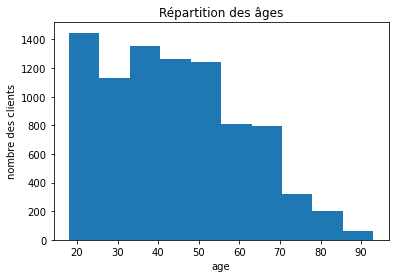

In [4]:
# Affiche l'histogramme des ages
plt.hist(customers["age"], 10)
plt.title("Répartition des âges")
plt.xlabel("age")
plt.ylabel("nombre des clients")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

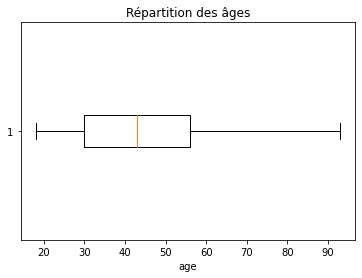

In [5]:
# Affiche la boîte à moustache des ages
plt.boxplot(customers.age, vert=False)
plt.title("Répartition des âges")
plt.xlabel("age")
plt.show

On test la normalité de la répartion des ages.

Hypothèse H0 : Le jeu de données suit une loi normale.

On réalise un test de Kolmogorov Smirnov pour tester la normalité.

In [6]:
#Test de Kolmogorov Smirnov pour tester l'adéquation à une loi normale
x= np.array(customers["age"], dtype=float)
x -= np.mean(x)
x /= np.std(x)
st.kstest(x,'norm')

KstestResult(statistic=0.06423379380873624, pvalue=2.2483631724784304e-31)

La pValue est inférieure à 0.05 donc on peut rejeter l'hypothèse H0 avec un taux de risque de 5%.

## II.b. Jointures de tables

La jointure entre les tables donne comme résultats :

-679 111 both, soit autant de transactions dont la référence produit est présente dans la table products

-221 Left only, soit 221 transactions donc le produit n'est pas référencé dans la table products, toujours le même produit 0_2245

-22 Right only, soit 22 produits dont aucune transactions ne figure dans la table transactions

In [7]:
#Jointure test transactions products
transactions2 = pd.merge(transactions, products, on="id_prod", how="outer", indicator=True)
#Datasets contenant les both, right only et left only
both=transactions2.loc[transactions2["_merge"]=="both"]
left_only=transactions2.loc[transactions2["_merge"]=="left_only"]
right_only=transactions2.loc[transactions2["_merge"]=="right_only"]
#Affiche le nombre de both, right only, left only
print("Both:")
print(both.id_prod.value_counts().sum())
print("Left only (transactions sans produits):")
print(left_only.id_prod.value_counts())
print("Right only (produits sans transactions):")
print(right_only.id_prod.value_counts().sum())
#Jointure finale transactions products
transactions2 = pd.merge(transactions, products, on="id_prod", how="inner")

Both:
679111
Left only (transactions sans produits):
0_2245    221
Name: id_prod, dtype: int64
Right only (produits sans transactions):
22


In [8]:
#Jointure test transactions customers
transactions3 = pd.merge(transactions, customers, on="client_id", how="outer", indicator=True)
#Datasets contenant les both, right only et left only
both2=transactions3.loc[transactions3["_merge"]=="both"]
left_only2=transactions3.loc[transactions3["_merge"]=="left_only"]
right_only2=transactions3.loc[transactions3["_merge"]=="right_only"]
#Affiche le nombre de both, right only, left only
print("Both:")
print(both2.id_prod.value_counts().sum())
print("Left only (transactions sans clients):")
print(left_only2.id_prod.value_counts().sum())
print("Right only (clients sans transactions):")
print(right_only2.id_prod.value_counts().sum())
#Jointure finale transactions customers
transactions3 = pd.merge(transactions, customers, on="client_id", how="left")

Both:
679332
Left only (transactions sans clients):
0
Right only (clients sans transactions):
0


In [9]:
#Jointure test transactions customers
transactions4 = pd.merge(transactions3, products, on="id_prod", how="outer", indicator=True)
#Datasets contenant les both, right only et left only
both3=transactions4.loc[transactions4["_merge"]=="both"]
left_only3=transactions4.loc[transactions4["_merge"]=="left_only"]
right_only3=transactions4.loc[transactions4["_merge"]=="right_only"]
#Affiche le nombre de both, right only, left only
print("Both:")
print(both3.id_prod.value_counts().sum())
print("Left only (Transactions avec produits non reconnus):")
print(left_only3.id_prod.value_counts().sum())
print("Right only (Produits sans transactions):")
print(right_only3.id_prod.value_counts().sum())
#Jointure finale transactions customers
transactions4 = pd.merge(transactions3, products, on="id_prod", how="inner")

Both:
679111
Left only (Transactions avec produits non reconnus):
221
Right only (Produits sans transactions):
22


La table transaction contenait à la base 679 332 lignes, après la jointure avec les tables cutomers et products elle n'en contient plus que 679 111, ce sont 221 lignes de transactions qui ont été perdues, qui correspondent à des transactions dont le produit n'apparaît pas dans la base de données (0_2245).

## II.c. Déclarations de variables

In [10]:
#Créé un Dataframe contenant les données de customers, transactions et products sans les outliers
transactions4_nootl = transactions4[(transactions4.client_id != "c_3454") & (transactions4.client_id != "c_6714") & (transactions4.client_id != "c_4958") & (transactions4.client_id != "c_1609")]
#Créé une liste qui réprésentera les tranches d'age
age_groups = [1, 18, 25, 35, 45, 55 , 65, 100]

# **III. Demandes d'Antoine**

## III.a. Chiffre d'affaire par mois

In [11]:
#Script qui retourne un dataframe contenant le chiffre d'affaire par mois
def CA_calc(df, col_price, col_date):
  start = df[col_date].min()
  finish = df[col_date].max()
  CA_1 = df[col_price].loc[(df[col_date].dt.month == start.month) & (df[col_date].dt.year == start.year)].sum()
  month_1 = start.month
  year_1 = start.year
  date_CA = pd.to_datetime(str(year_1) + "-" + str(month_1))
  CA = pd.DataFrame(columns=["date", "CA"])
  CA = CA.append({'date': date_CA, 'CA': CA_1}, ignore_index=True)
  while year_1 < finish.year :
    while month_1 <12 :
      month_1 += 1
      date_CA = pd.to_datetime(str(year_1) + "-" + str(month_1))
      CA_1 = df[col_price].loc[(df[col_date].dt.month == month_1) & (df[col_date].dt.year == year_1)].sum()
      CA = CA.append({'date': date_CA, 'CA': CA_1}, ignore_index=True)
    else :
      year_1 += 1
      month_1 = 1
      date_CA = pd.to_datetime(str(year_1) + "-" + str(month_1))
      CA_1 = df[col_price].loc[(df[col_date].dt.month == month_1) & (df[col_date].dt.year == year_1)].sum()
      CA = CA.append({'date': date_CA, 'CA': CA_1}, ignore_index=True)
  else :
    while month_1 < finish.month :
      month_1 += 1
      date_CA = pd.to_datetime(str(year_1) + "-" + str(month_1))
      CA_1 = df[col_price].loc[(df[col_date].dt.month == month_1) & (df[col_date].dt.year == year_1)].sum()
      CA = CA.append({'date': date_CA, 'CA': CA_1}, ignore_index=True)
  return(CA)

In [12]:
# Calcule le chiffre d'affaire par mois avec la fonction, sert pour les dates
CA_date = CA_calc(transactions2, "price", "date")

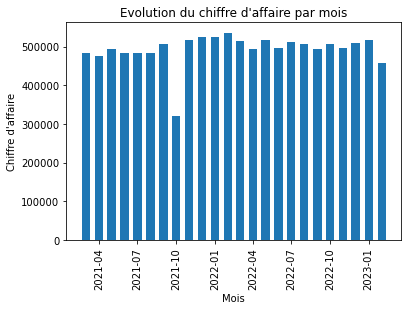

In [13]:
# Calcule les chiffres d'affaire par mois
CA = transactions2.groupby([pd.Grouper(key='date', freq='1M')]).sum()
# Renomme la colonne price en CA
CA = CA.rename(columns={"price":"CA"})
# Drop la colonne categ
CA = CA.drop(columns="categ")
#Affiche les chiffres d'affaires par mois sur un graphique à barres
x=CA_date.date
y=CA["CA"]
plt.bar(x, y, width=20)
plt.xticks(rotation=90)
plt.title("Evolution du chiffre d'affaire par mois")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaire")
plt.show()

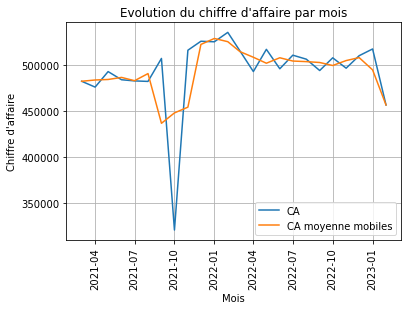

In [14]:
#Affiche les chiffres d'affaires par mois sur un graphique
x=CA_date.date
y=CA["CA"]
ax = plt.subplot(111)
CAplot = plt.plot(x,y, label="CA")
moymobplot = plt.plot(x,moy_mob(CA.CA), label="CA moyenne mobiles")
plt.xticks(rotation=90)
plt.title("Evolution du chiffre d'affaire par mois")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaire")
plt.legend(loc="best")
plt.grid()
plt.show()

In [15]:
# Donne le mode pour les transactions
transactions_mode = transactions2.mode()
transactions_mode.iloc[0]

id_prod                            1_369
date          2021-03-01 00:01:07.843138
session_id                      s_118668
client_id                         c_1609
price                              15.99
categ                                0.0
Name: 0, dtype: object

In [16]:
# Calcule et affiche le prix moyen et le prix médian
transactions_moyenne = transactions2.price.mean()
transactions_median = transactions2.price.median()
print("Prix moyen :",transactions_moyenne)
print("Prix median :",transactions_median)

Prix moyen : 17.454773490733356
Prix median : 13.99


In [17]:
# Calcule l'écart-type des transactions
transactions_deviation = transactions2.price.std()
print("En moyenne les transactions présentent un écart de", round(transactions_deviation), "par rapport à la moyenne des transactions.")

En moyenne les transactions présentent un écart de 18 par rapport à la moyenne des transactions.


In [18]:
#Calcule le nombre de transactions par mois
Nb_transactions = transactions2.groupby([pd.Grouper(key='date', freq='1M')]).count()
#Drop les colonnes inutiles
Nb_transactions.drop(Nb_transactions.iloc[:, 1:5], inplace = True, axis = 1)
#Renomme id_prod en Nb_transactions
Nb_transactions = Nb_transactions.rename(columns={"id_prod":"Nb_transactions"})
#Retire les données pour Octobre 2021
Nb_transactions_Oct2021 = Nb_transactions.iloc[7]
Nb_transactions = Nb_transactions[Nb_transactions.Nb_transactions != 21599]
print("Nombre moyen de transactions par mois : ",round(Nb_transactions.Nb_transactions.mean()))

Nombre moyen de transactions par mois :  28587


## III.b. Chiffre d'affaire d'Octobre 2021

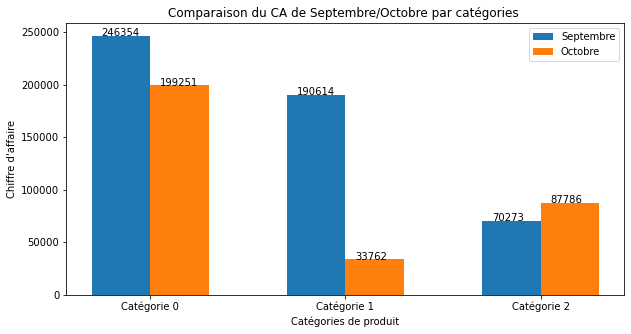

In [19]:
#Isoler les données de ventes d'Octobre 2021
Novembre_2021 = "2021-11"
Novembre_2021 = pd.to_datetime(Novembre_2021)
Octobre_2021 = "2021-10"
Octobre_2021 = pd.to_datetime(Octobre_2021)
transactions_21_10 = transactions2.loc[transactions2.date<Novembre_2021]
transactions_21_10 = transactions_21_10.loc[transactions_21_10.date>Octobre_2021]

#Isoler les données de ventes de Septembre 2021
Septembre_2021 = "2021-09"
Septembre_2021 = pd.to_datetime(Septembre_2021)
transactions_21_09 = transactions2.loc[transactions2.date<Octobre_2021]
transactions_21_09 = transactions_21_09.loc[transactions_21_09.date>Septembre_2021]

categ_21_10 = transactions_21_10.groupby(by="categ").sum()
categ_21_09 = transactions_21_09.groupby(by="categ").sum()

#Converti les dataframe en series
categ_21_10 = categ_21_10.price.squeeze(axis=0)
categ_21_09 = categ_21_09.price.squeeze(axis=0)

# Nombre de barres pour le graph
N=3
# Position des barres sur l'axe des abscisses
ind = np.arange(N)
# Règle la taille de la figure
plt.figure(figsize=(10,5))
# Règle la largeur des barres
width = 0.3
# Créé les barres
h=plt.bar(ind, categ_21_09 , width, label='Septembre')
f=plt.bar(ind + width, categ_21_10, width, label='Octobre')
# Affiche le nom des axes
plt.xlabel('Catégories de produit')
plt.ylabel("Chiffre d'affaire")
#Affiche le titre
plt.title('Comparaison du CA de Septembre/Octobre par catégories ')
# Affiche les noms des ticks de l'axe des abscisses
plt.xticks(ind + width / 2, ('Catégorie 0', 'Catégorie 1', 'Catégorie 2'))
# Affiche la légende
plt.legend(loc='best')

for i in range(3):
  plt.text(-0.1+i, categ_21_09.iloc[0+i], str(round(categ_21_09.iloc[0+i])))
  plt.text(0.2+i, categ_21_10.iloc[0+i], str(round(categ_21_10.iloc[0+i])))
#Faire des tests entre variables
plt.show()

In [20]:
# Isole les données de transactions d'Octobre 2021 pour la catégorie 1
transactions_21_10_c1 = transactions_21_10.loc[transactions_21_10.categ==1]
# Fait la somme des transactions par produits
transactions_21_10_c1 = transactions_21_10_c1.groupby(by="id_prod", as_index=False).sum()
# Supprimme les colonnes inutiles
transactions_21_10_c1 = transactions_21_10_c1.drop(columns=["categ"])
# Renomme la colonne price
transactions_21_10_c1 = transactions_21_10_c1.rename(columns={"price":"CA Octobre 2021"})
# Affiche le top 10 du chiffre d'affaire par produit
print(transactions_21_10_c1.sort_values(by="CA Octobre 2021", ascending=False).head(10))
# Affiche le nombre de produits présents dans la liste
len(transactions_21_10_c1)

    id_prod  CA Octobre 2021
159   1_432           532.40
177   1_456           424.05
134   1_383           405.86
142   1_395           405.86
143   1_396           390.60
125   1_369           359.85
174   1_451           356.83
88    1_301           335.88
155   1_417           335.84
154   1_414           333.62


376

In [21]:
# Isole les données de transactions de Septembre 2021 pour la catégorie 1
transactions_21_09_c1 = transactions_21_09.loc[transactions_21_09.categ==1]
# Fait la somme des transactions par produits
transactions_21_09_c1 = transactions_21_09_c1.groupby(by="id_prod", as_index=False).sum()
# Supprimme les colonnes inutiles
transactions_21_09_c1 = transactions_21_09_c1.drop(columns=["categ"])
# Renomme la colonne price
transactions_21_09_c1 = transactions_21_09_c1.rename(columns={"price":"CA Septembre 2021"})
# Affiche le top 10 du chiffre d'affaire par produit
print(transactions_21_09_c1.sort_values(by="CA Septembre 2021", ascending=False).head(10))
# Affiche le nombre de produits présents dans la liste
len(transactions_21_09_c1)

    id_prod  CA Septembre 2021
234   1_369            2351.02
248   1_385            2339.10
254   1_395            2290.21
278   1_431            2127.24
246   1_383            2058.29
269   1_414            1954.06
270   1_417            1952.07
251   1_389            1899.24
232   1_366            1798.02
326   1_498            1776.12


599

<function matplotlib.pyplot.show(close=None, block=None)>

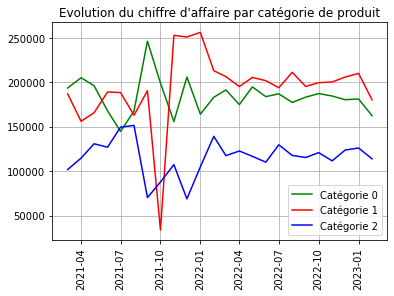

In [22]:
# Calcule le chiffre d'affaire par mois et par catégorie
CA_pmc = transactions2.groupby([pd.Grouper(key='date', freq='1M'), "categ"]).sum()
# Calcule le chiffre d'affaire par mois pour chaque catégorie
idx = pd.IndexSlice
CA_pmc0 = CA_pmc.loc[idx[:, 0], :]
CA_pmc1 = CA_pmc.loc[idx[:, 1], :]
CA_pmc2 = CA_pmc.loc[idx[:, 2], :]
# Affiche le chiffre d'affaire par mois pour chaque catégorie sous forme de courbes
ax = plt.subplot(111)
CA_pmc0c = plt.plot(x, CA_pmc0.price, color='green', label='Catégorie 0')
CA_pmc1c = plt.plot(x, CA_pmc1.price, color='red', label='Catégorie 1')
CA_pmc2c = plt.plot(x, CA_pmc2.price, color='blue', label='Catégorie 2')
plt.xticks(rotation=90)
plt.title("Evolution du chiffre d'affaire par catégorie de produit")
plt.legend(loc='best')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

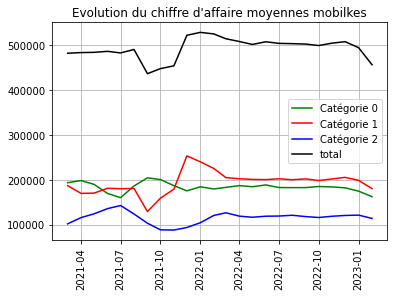

In [23]:
#Caclule les moyennes mobiles pour le CA
moy_mob_CA = moy_mob(CA.CA)
moyennes_mobiles0 = moy_mob(CA_pmc0["price"])
moyennes_mobiles1 = moy_mob(CA_pmc1["price"])
moyennes_mobiles2 = moy_mob(CA_pmc2["price"])
# Affiche le chiffre d'affaire par mois en moyenes mobiles pour chaque catégorie sous forme de courbes
ax = plt.subplot(111)
CA_mm0c = plt.plot(x, moyennes_mobiles0, color='green', label='Catégorie 0')
CA_mm1c = plt.plot(x, moyennes_mobiles1, color='red', label='Catégorie 1')
CA_mm2c = plt.plot(x, moyennes_mobiles2, color='blue', label='Catégorie 2')
CA_moy_mob = plt.plot(x, moy_mob_CA, color='black', label='total')
plt.xticks(rotation=90)
plt.title("Evolution du chiffre d'affaire moyennes mobilkes")
plt.legend(loc='best')
plt.grid()
plt.show

In [24]:
# Jointure de table pour identifier les différences de produits dans les transactions de Septembre 2021 et Octobre 2021
Manque_10_21 = pd.merge(transactions_21_10_c1,transactions_21_09_c1,on="id_prod", how="outer", indicator=True)
# Compte le nombre de produits manquants pour Octobre 2021 par rapport à Septembre 2021
p_manquant = len(Manque_10_21.loc[Manque_10_21._merge=="right_only"])
# Compte le nombre total de produits en catégorie 1
p_categ1 = len(products.loc[products.categ==1])
print(p_manquant,"produits de catégorie 1 qui se sont vendus en Septembre 2021 sont absents des ventes d'Octobre 2021, sur ", p_categ1, " produits de catégorie 1, soit ",round(p_manquant/p_categ1*100),"% des produits de catégorie 1.")

245 produits de catégorie 1 qui se sont vendus en Septembre 2021 sont absents des ventes d'Octobre 2021, sur  739  produits de catégorie 1, soit  33 % des produits de catégorie 1.


C:\Users\ThyEx\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


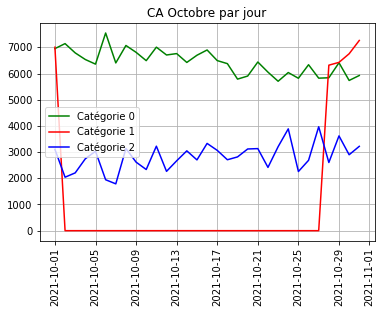

In [25]:
trans_oct_perday = transactions_21_10.groupby([pd.Grouper(key='date', freq='1D'), "categ"]).sum()
# Calcule le chiffre d'affaire par mois pour chaque catégorie
idx = pd.IndexSlice
trans_oct_perday0 = trans_oct_perday.loc[idx[:, 0], :]
trans_oct_perday1 = trans_oct_perday.loc[idx[:, 1], :]

#prépare les données pour la catégorie 1
trans_oct_temp = trans_oct_perday0
trans_oct_temp.price.iloc[0] = trans_oct_perday1.price.iloc[0]
trans_oct_temp.price.iloc[1:27] = 0
#print(trans_oct_perday0)
trans_oct_temp.price.iloc[27:31] = trans_oct_perday1.price.iloc[1:5]
trans_oct_perday1 = trans_oct_temp

#Prépare les données pour les dates de l'axe des abscisses
datesindex = trans_oct_perday0
datesindex.index = datesindex.index.droplevel(1)
datesindex
xdates=datesindex.index

trans_oct_perday0 = trans_oct_perday.loc[idx[:, 0], :]
trans_oct_perday2 = trans_oct_perday.loc[idx[:, 2], :]
# Affiche le chiffre d'affaire par mois pour chaque catégorie sous forme de courbes
ax = plt.subplot(111)
trans_oct_perday0g = plt.plot(xdates, trans_oct_perday0.price, color='green', label='Catégorie 0')
trans_oct_perday1g = plt.plot(xdates, trans_oct_perday1.price, color='red', label='Catégorie 1')
trans_oct_perday2g = plt.plot(xdates, trans_oct_perday2.price, color='blue', label='Catégorie 2')
plt.xticks(rotation=90)
plt.title("CA Octobre par jour")
plt.legend(loc='best')
plt.grid()
plt.show()

Si on observe les ventes par jour on voit que des données semblent manquer pour la catégorie 1 du 2 au 27 Octobre.

## III.c. Nombre de ventes par produit

In [26]:
#Créé un dataframe contenant le nombre de ventes par produit
product_sales = pd.DataFrame(transactions2.id_prod.value_counts().reset_index().values, columns=["id_prod", "sales"])
#Range les valeurs par ordre décroissant
product_sales = product_sales.sort_index(axis = 0, ascending=True)
#Affiche le top 10
print(product_sales.head(10))
#Range les valeurs par ordre croissant et affiche le top 10
print(product_sales.sort_values(by="sales", ascending=True).head(10))

  id_prod sales
0   1_369  2252
1   1_417  2189
2   1_414  2180
3   1_498  2128
4   1_425  2096
5   1_403  1960
6   1_412  1951
7   1_413  1945
8   1_406  1939
9   1_407  1935
     id_prod sales
3264    2_98     1
3247   0_549     1
3248    2_81     1
3249  0_1379     1
3250   0_541     1
3251   0_886     1
3252  0_1728     1
3253   0_807     1
3254  0_1284     1
3263  0_1539     1


## III.d. Nombre de ventes par client

In [27]:
# Affiche le nombre de ventes par client
transactions2.client_id.value_counts().head(10)

c_1609    25488
c_6714     9181
c_3454     6770
c_4958     5195
c_3263      403
c_2140      402
c_2595      398
c_2077      384
c_1637      380
c_7421      379
Name: client_id, dtype: int64

## III.e. Chiffre d'affaire par produit

In [28]:
#Regroupe les transactions par id de produit et fait la somme des transactions
CA_produit = transactions2.groupby(by="id_prod").sum()
#Renomme la colonne price en CA
CA_produit = CA_produit.rename(columns={"price":"CA"})
#Drop la colonne categ
CA_produit = CA_produit.drop(columns=["categ"])
#Affiche les résultats, top 10 par le haut et par le bas
print("Tops:")
print(CA_produit.sort_values(by="CA", ascending=False).head(10))
print("Flops:")
print(CA_produit.sort_values(by="CA", ascending=True).head(10))

Tops:
               CA
id_prod          
2_159    94893.50
2_135    69334.95
2_112    65407.76
2_102    60736.78
2_209    56971.86
1_395    54356.25
1_369    54025.48
2_110    53846.25
2_39     53060.85
2_166    52449.12
Flops:
           CA
id_prod      
0_1539   0.99
0_1284   1.38
0_1653   1.98
0_1601   1.99
0_807    1.99
0_541    1.99
0_1728   2.27
0_1498   2.48
0_898    2.54
0_1840   2.56


## III.f. Nombre de ventes par catégories de produit

Nombre de ventes par catégories de produits
   categ   sales
0      0  415459
1      1  227169
2      2   36483


<function matplotlib.pyplot.show(close=None, block=None)>

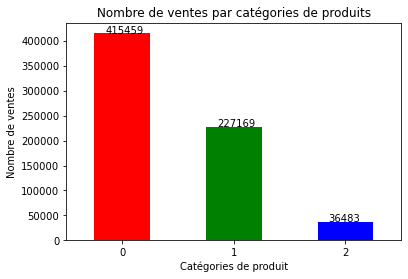

In [29]:
#Nombre de ventes par catégories de produits
print("Nombre de ventes par catégories de produits")
#Compte le nombre d'occurences pour les valeurs de la colonne categ
product_sales = pd.DataFrame(transactions2.categ.value_counts().reset_index().values, columns=["categ", "sales"])
#Organise les données par ordre décroissant
product_sales = product_sales.sort_index(axis = 0, ascending=True)
print(product_sales)

#graphique à barres pour afficher les données
product_sales.sales.plot.bar(color = ["red","green","blue"])
plt.xticks(rotation=0)
plt.title("Nombre de ventes par catégories de produits")
plt.xlabel("Catégories de produit")
plt.ylabel("Nombre de ventes")
for i in range(3):
  plt.text(-0.15+i, product_sales.sales.iloc[0+i], str(round(product_sales.sales.iloc[0+i],2)))
plt.show

## III.g. Chiffre d'affaire par catégorie de produits

<function matplotlib.pyplot.show(close=None, block=None)>

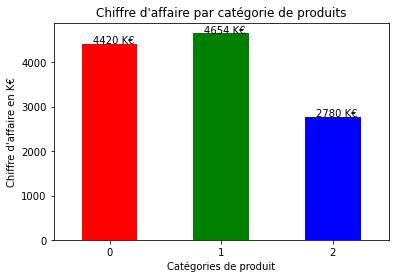

In [30]:
#Regroupe les transactions par catégories et fait la somme des transactions
CA_produit = transactions2.groupby(by="categ").sum()
#Renomme la colonne price en CA
CA_produit = CA_produit.rename(columns={"price":"CA"})
#Converti en K€
CA_produit.CA = CA_produit.CA/1000

#Affiche le graphique des données
CA_produit.CA.plot.bar(color = ["red","green","blue"])
plt.xticks(rotation=0)
plt.title("Chiffre d'affaire par catégorie de produits")
plt.xlabel("Catégories de produit")
plt.ylabel("Chiffre d'affaire en K€")
#Affiche les données sur le graph
for i in range(3):
  plt.text(-0.15+i, CA_produit.CA.iloc[0+i], str(round(CA_produit.CA.iloc[0+i]))+" K€")
plt.show

## III.h. Courbe de Lorenz

In [31]:
#Calcule le chiffre d'affaire total
CA_total = transactions2["price"].sum()
#Prépare un nouveau dataframe sans données superflues
CA_client = transactions2.drop(["id_prod", "date", "session_id", "categ"], axis=1)
#Regroupe les données par id de client et fait la somme des données
CA_client = CA_client.groupby(by=["client_id"], as_index=False).sum()

print(CA_client.sort_values(by="price", ascending=False).head(10))
print(CA_client.sort_values(by="price", ascending=True).head(10))
print()
print("Chiffre d'affaire total:")
print(round(CA_total,2))

     client_id      price
677     c_1609  324033.35
4388    c_4958  289760.34
6337    c_6714  153598.92
2724    c_3454  113637.93
2513    c_3263    5276.87
634     c_1570    5271.62
2108    c_2899    5214.05
1268    c_2140    5208.82
7006    c_7319    5155.77
7715    c_7959    5085.45
     client_id  price
8151    c_8351   6.31
7918    c_8140   8.30
7889    c_8114   9.98
1556     c_240  11.06
4044    c_4648  11.20
3855    c_4478  13.36
5501    c_5962  13.99
5589    c_6040  15.72
5453    c_5919  15.98
5354    c_5829  16.07

Chiffre d'affaire total:
11853728.68


<function matplotlib.pyplot.show(close=None, block=None)>

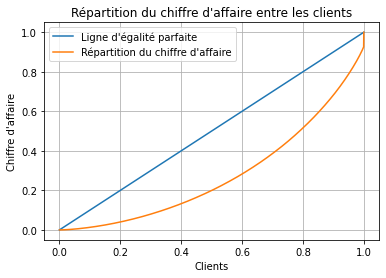

In [32]:
#Organise les données par ordre croissant
CA_client = CA_client.sort_values(by="price", ascending=True)
#Créé la colonne cum_client qui correspond au nombre cumulé de client
CA_client["cum_client"]=1
CA_client["cum_client"] = CA_client["cum_client"].cumsum()/len(CA_client)
#Créé la colonne cum_price qui correspont au chiffre d'affaire cumulé que réprésente chaque client
CA_client["cum_price"] = CA_client["price"].cumsum()/CA_total
#Créé la courbe de Lorenz parfaite
lorenz_x = [0,1]
lorenz_y= [0,1]
plt.plot(lorenz_x, lorenz_y, label="Ligne d'égalité parfaite")
#Créé la courbe de Lorenz réprésentant la répartition du chiffre d'affaire entre les clients
plt.plot(CA_client["cum_client"], CA_client["cum_price"], label="Répartition du chiffre d'affaire")
plt.xlabel("Clients")
plt.ylabel("Chiffre d'affaire")
plt.title("Répartition du chiffre d'affaire entre les clients")
plt.legend(loc='best')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

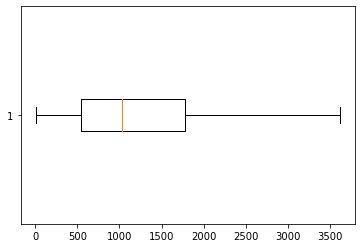

In [33]:
# Affiche le chiffre d'affaire par client sous forme de boîte à moustache sans les outliers
plt.boxplot(CA_client.price,showfliers= False, vert = False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

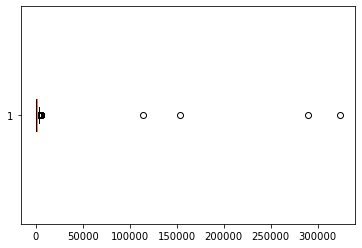

In [34]:
# Affiche le chiffre d'affaire par client sous forme de boîte à moustache avec les outliers
plt.boxplot(CA_client.price, vert = False)
plt.show


In [35]:
# Calcule les quartiles pour le CA par client ainsi que le min et le max
quartiles = CA_client.price.quantile([0.25,0.5,0.75])
etq = quartiles.iloc[2] - quartiles.iloc[0]
min = quartiles.iloc[0] - (etq*1.5)
max = quartiles.iloc[2] + (etq*1.5)
max

3627.305

# **IV. Demandes de Julie**

## IV.a. Lien entre le genre d’un client et les catégories des livres achetés

Hypothèse H0 : Les deux variables sont indépendantes

On réalise un test du χ2 d'indépendance.

On commence par créer un tableau de contingence qui donne le rapport entre les 2 paramètres observés.

In [36]:
# Prépare les donnés de catégories par genre en supprimant les colonnes inutiles
categ_par_genre = transactions4_nootl.drop(columns=["id_prod","date","session_id","birth","age","price"])
# Drop les doublons pour ne garder qu'une seule instance d'un client pour un achat dans une catégorie
categ_par_genre = categ_par_genre.drop_duplicates(keep="first")
# Créé une table de contingence qui crois les données de sex et d'achat par catégorie
categ_par_genre2 = pd.crosstab(categ_par_genre["categ"], categ_par_genre["sex"], margins=True)
categ_par_genre3 = pd.crosstab(categ_par_genre["categ"], categ_par_genre["sex"], margins=False)
categ_par_genre2

sex,f,m,All
categ,,,
0,4119,3773,7892
1,4391,4058,8449
2,1839,1754,3593
All,10349,9585,19934


On cherche à comparer l'écart entre notre distribution et une distribution théorique qu'on obtiendrait si les 2 paramètres étaient indépendants.

La valeur d'une case de la distribution théorique s'obtient en multipliant le total de la ligne par celui de la colonne et en divisant par le total général.

In [37]:
#Créé un Dataframe avec la distribution théorique.
data = {'categ0':[4097, 3795, 7892],'categ1':[4386, 4063, 8449], 'categ2':[1865, 1728, 3593], 'All':[10349, 9585, 19934]}
pd.DataFrame(data=data, index=["f","m", "All"])

,categ0,categ1,categ2,All
f,4097,4386,1865,10349
m,3795,4063,1728,9585
All,7892,8449,3593,19934


On réalise ensuite le test du Chi2 qui nous donne une pValue dont la valeur nous indique si on rejetera ou non l'hypothèse H0. Si la pValue est inférieur à notre taux de risque alors on rejette l'hypothèse H0 au profit de l'hypothèse alternative, dans le cas contraire on conserve l'hypothèse H0.

In [38]:
# Réalise le test du Chi2 pour vérifier si les variables sex et catégorie de produit acheté sont indépendantes ou non
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(categ_par_genre2)
print("Satistique chi2 : ",st_chi2)
print("P value :",st_p)
print("Degrès de liberté :",st_dof)
# Compare la Pvalue au seuil de 5%
print("st_p>=0.05 :",st_p>=0.05)

Satistique chi2 :  1.0247280956599478
P value : 0.9846575173150158
Degrès de liberté : 6
st_p>=0.05 : True


La Pvaleur est supérieure à 0.05 donc on ne rejette pas l'hypothèse H0 avec un niveau de risque de 5%, les variables sont indépendantes.

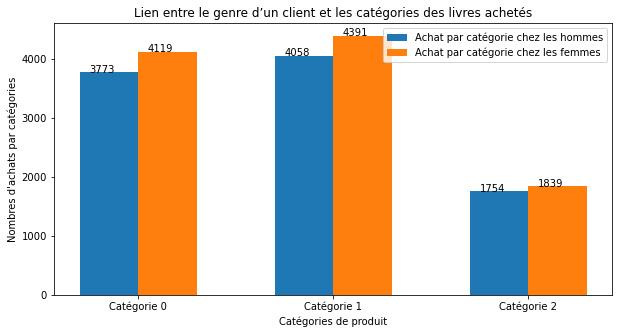

In [39]:
# Nombre de barres pour le graph
N=3
# Données pour les barres
homme = categ_par_genre3.m
femme = categ_par_genre3.f
# Position des barres sur l'axe des abscisses
ind = np.arange(N)
# Règle la taille de la figure
plt.figure(figsize=(10,5))
# Règle la largeur des barres
width = 0.3
# Créé les barres
h=plt.bar(ind, homme , width, label='Achat par catégorie chez les hommes')
f=plt.bar(ind + width, femme, width, label='Achat par catégorie chez les femmes')

# Affiche le nom des axes
plt.xlabel('Catégories de produit')
plt.ylabel("Nombres d'achats par catégories")
#Affiche le titre
plt.title('Lien entre le genre d’un client et les catégories des livres achetés')
# Affiche les noms des ticks de l'axe des abscisses
plt.xticks(ind + width / 2, ('Catégorie 0', 'Catégorie 1', 'Catégorie 2'))
# Affiche la légende
plt.legend(loc='best')

for i in range(3):
  plt.text(-0.1+i, homme.iloc[0+i], str(homme.iloc[0+i]))
  plt.text(0.2+i, femme.iloc[0+i], str(femme.iloc[0+i]))
#Faire des tests entre variables
plt.show()

## IV.b. Total des achats par tranches d'âge

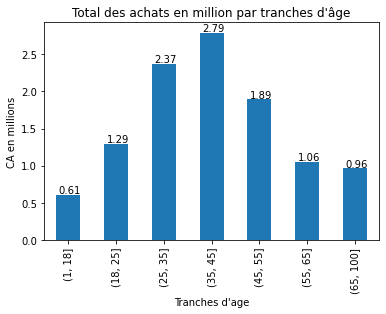

In [40]:
#Regroupe les transactions par groupe d'age et fait leur somme
total_achat_age = transactions4_nootl
total_achat_age = total_achat_age["price"].groupby(pd.cut(total_achat_age.age, age_groups)).sum()
total_achat_age = total_achat_age/1000000
#affiche les données sous forme de diagramme à barres
total_achat_age.plot.bar()
plt.xlabel("Tranches d'age")
plt.ylabel("CA en millions")
plt.title("Total des achats en million par tranches d'âge")
#Affiche les données sur le graph
for i in range(7):
  plt.text(-0.20+i, total_achat_age.iloc[0+i]+0.02, str(round(total_achat_age.iloc[0+i],2)))
plt.show()

In [41]:
# Prépare un Dataframe contenant uniquement les données id_client, age et price
tachat_perage = transactions4_nootl.drop(columns=["id_prod","date","session_id", "sex", "categ", "birth"])
# Groupby client_id et age pour avoir le total des achat par client et leur age
tachat_perage = tachat_perage.groupby(["client_id", "age"], as_index=False)["price"].sum()
tachat_perage = tachat_perage.rename(columns={"price":"total_achat"})

H0 : le jeu de données suit une loi normale

In [42]:
#Test de Kolmogorov Smirnov pour tester l'adéquation à une loi normale
x -= np.mean(x)
x /= np.std(x)
st.kstest(tachat_perage["total_achat"], 'norm')

KstestResult(statistic=0.9999999998604823, pvalue=0.0)

La Pvalue est inférieure à 0.05 donc on rejette l'hypothèse H0 d'adéquation à une loi normale.

In [43]:
# Créé une table par tranche d'age pour le test de Kruskal
tachat_moins18 = tachat_perage.loc[tachat_perage.age<=18]
tachat18_25 = tachat_perage.loc[(tachat_perage.age>18) & (tachat_perage.age<=25)]
tachat25_35 = tachat_perage.loc[(tachat_perage.age>25) & (tachat_perage.age<=35)]
tachat35_45 = tachat_perage.loc[(tachat_perage.age>35) & (tachat_perage.age<=45)]
tachat45_55 = tachat_perage.loc[(tachat_perage.age>45) & (tachat_perage.age<=55)]
tachat55_65 = tachat_perage.loc[(tachat_perage.age>55) & (tachat_perage.age<=65)]
tachat_65plus = tachat_perage.loc[tachat_perage.age>65]

Pour tester la corrélation entre 1 variable qualitative et une variable quantitative on peut réaliser un test d'Anova.

H0 : Les moyennes des différents groupes sont égales, il n'y a donc pas de corrélation.

In [44]:
# Réalise le test d'Anova
Fstat, pvalue = st.f_oneway(tachat_moins18.total_achat, tachat18_25.total_achat, tachat25_35.total_achat, tachat35_45.total_achat, tachat45_55.total_achat, tachat55_65.total_achat, tachat_65plus.total_achat)
print("Pvalue : ", pvalue)
pvalue<=0.05

Pvalue :  4.681514746200481e-113


True

Notre pValue est inférieure à 0.05, on peut donc rejetter l'hypothèse H0 et conclure à l'existence d'une corrélation entre les variables.

Etant donné que nos 2 jeux de données ne suivent pas une loi normale, on préfèrera le test de Kruskal, non paramétrique, à la place du test d'Anova.

Hypothèse H0 : Les médianes de tous les groupes sont proches, il n'y a donc pas de relation entre les variables.

In [45]:
# Réalise le test de Kruskal
Fstat, pvalue = st.kruskal(tachat_moins18.total_achat, tachat18_25.total_achat, tachat25_35.total_achat, tachat35_45.total_achat, tachat45_55.total_achat, tachat55_65.total_achat, tachat_65plus.total_achat)
print("Pvalue : ", pvalue)
pvalue<=0.05

Pvalue :  8.106618551113491e-99


True

La Pvalue est inférieure à 0.05 donc on rejette l'hypothèse H0, les moyennes ne sont pas égales, il y a donc une relation entre les variables.

On peut aussi considérer les 2 paramètres comme étant quantitatif, on tente alors un calcule du coefficient de corrélation de Spearman pour tester la corrélation entre les 2 paramètres.

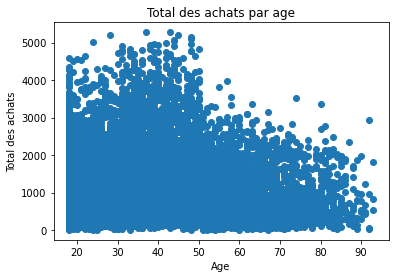

In [46]:
# Affiche le total des achats par l'age pour chaque client sous forme de nuage de points
plt.scatter(tachat_perage.age, tachat_perage.total_achat)
plt.xlabel("Age")
plt.ylabel("Total des achats")
plt.title("Total des achats par age")
plt.show()

Sur le nuage de points le total des achats semble diminuer quand l'age augmente, on effectue une régréssion linéaire pour voir si une corrélation pourrait exister entre les deux paramètres.

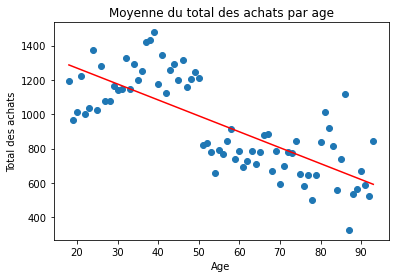

-9.27152768284347


In [47]:
# Calcule la moyenne du total des achats par age
tachat_perage2 = tachat_perage.groupby(by="age", as_index=False).median()
# Calcule la régression linéaire entre total des achats et age
slope, intercept, r_value, p_value, std_err = st.linregress(tachat_perage2.age, tachat_perage2.total_achat)
regression_lineaire = (slope*tachat_perage2.age)+intercept
# Affiche le total des achats par l'age pour chaque client sous forme de nuage de points et la regression linéaire
plt.scatter(tachat_perage2.age, tachat_perage2.total_achat)
plt.plot(tachat_perage2.age, regression_lineaire, color="red")
plt.xlabel("Age")
plt.ylabel("Total des achats")
plt.title("Moyenne du total des achats par age")
plt.show()
print(slope)

In [48]:
tachat_perage2

,age,total_achat
0,18,1193.450
1,19,967.070
2,20,1011.130
3,21,1223.720
4,22,999.130
...,...,...
71,89,562.200
72,90,666.565
73,91,585.510
74,92,520.960


Notre régression linéaire indique une potentielle corrélation entre les 2 paramètres, on cherche à vérifier cela au travers de tests statistiques.

On tente de calculer le coefficient de Pearson.

Hypothèse H0 : Les données ne sont pas corrélées.

In [49]:
#Coefficient de Pearson
st.pearsonr(tachat_perage.age,tachat_perage.total_achat)

(-0.1883761792721943, 1.7101053363389715e-69)

La pValue est inférieure à 0.05, on peut donc rejeter l'hypothèse H0 et conclure à une corrélation entre les 2 paramètres.

Le coefficient de Pearson présume que les données sont normalement distribuées, hors ici ce n'est pas le cas, on préférera donc l'utilisation du coefficient de Spearman.

Hypothèse H0 : Les données ne sont pas corrélées.

In [50]:
#Coefficient de Spearman
st.spearmanr(tachat_perage.age,tachat_perage.total_achat)

SpearmanrResult(correlation=-0.18513759917564593, pvalue=3.797551375418047e-67)

On obtient une pValue inférieure à 0.05, on rejette donc l'hypothèse H0, les données sont corrélées.

Une corrélation négative avec le coefficient de Spearman indique que lorsque l'un des paramètres augmente, l'autre diminue.

## IV.c. Fréquence d'achat par tranches d'âge

age
(1, 18]       631.208333
(18, 25]     1344.333333
(25, 35]     5120.791667
(35, 45]     8763.458333
(45, 55]     5479.083333
(55, 65]     2620.625000
(65, 100]    2393.708333
Name: price, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

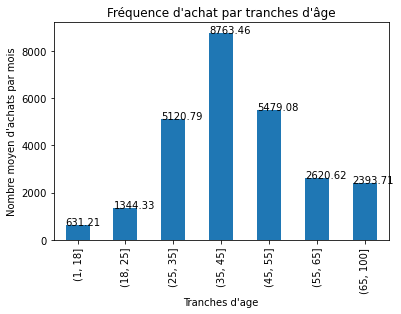

In [51]:
#Regroupe les données par tranches d'age, compte le nombre de transactions et le divise par le nombre de mois
freq_achat_age = transactions4_nootl["price"].groupby(pd.cut(transactions4_nootl.age, age_groups)).count()/24
print(freq_achat_age)
#Affiche le diagramme à barres
freq_achat_age.plot.bar()
plt.xlabel("Tranches d'age")
plt.ylabel("Nombre moyen d'achats par mois")
plt.title("Fréquence d'achat par tranches d'âge")
#Affiche les données sur le graph
for i in range(7):
  plt.text(-0.25+i, freq_achat_age.iloc[0+i], str(round(freq_achat_age.iloc[0+i],2)))
plt.show

In [52]:
# Compte le nombre d'achat par client et le divise par le nombre de mois
freqs_achat = transactions4_nootl.client_id.value_counts()/24
# Converti les données en dataframe
freqs_achat = pd.DataFrame(freqs_achat)
# Renomme la colonne clien_id
freqs_achat = freqs_achat.rename(columns={"client_id":"frequence_achat"})
# Créé la colonne client_id
freqs_achat["client_id"] = freqs_achat.index
# Jointure entre freqs_achat et customers pour avoir la liste des clients et leur fréquence d'achat par mois
freqs_achat_perage = pd.merge(customers, freqs_achat, on="client_id", how="inner")
freqs_achat_perage

,client_id,sex,birth,age,frequence_achat
0,c_4410,f,1967,55,3.166667
1,c_7839,f,1975,47,1.500000
2,c_1699,f,1984,38,0.625000
3,c_5961,f,1962,60,3.166667
4,c_5320,m,1943,79,1.000000
...,...,...,...,...,...
8591,c_7920,m,1956,66,4.291667
8592,c_7403,f,1970,52,6.833333
8593,c_5119,m,1974,48,1.958333
8594,c_5643,f,1968,54,5.250000


In [53]:
#Test de Kolmogorov Smirnov pour tester l'adéquation à une loi normale
x= np.array(freqs_achat_perage["frequence_achat"], dtype=float)
x -= np.mean(x)
x /= np.std(x)
st.kstest(x,'norm')

KstestResult(statistic=0.1591709471106818, pvalue=1.0374181653423456e-190)

La Pvalue est inférieure à 0.05 donc on rejette l'hypothèse H0 d'adéquation à une loi normale.

In [54]:
# Créé une table par tranche d'age pour le test de Kruskal
frap_moins18 = freqs_achat_perage.loc[freqs_achat_perage.age<=18]
frap18_25 = freqs_achat_perage.loc[(freqs_achat_perage.age>18) & (freqs_achat_perage.age<=25)]
frap25_35 = freqs_achat_perage.loc[(freqs_achat_perage.age>25) & (freqs_achat_perage.age<=35)]
frap35_45 = freqs_achat_perage.loc[(freqs_achat_perage.age>35) & (freqs_achat_perage.age<=45)]
frap45_55 = freqs_achat_perage.loc[(freqs_achat_perage.age>45) & (freqs_achat_perage.age<=55)]
frap55_65 = freqs_achat_perage.loc[(freqs_achat_perage.age>55) & (freqs_achat_perage.age<=65)]
frap65plus = freqs_achat_perage.loc[freqs_achat_perage.age>65]

Pour tester la corrélation entre 1 variable qualitative et une variable quantitative on peut réaliser un test d'Anova.

H0 : Les moyennes des différents groupes sont égales, il n'y a donc pas de corrélation.

In [55]:
# Réalise le test d'Anova
Fstat, pvalue = st.f_oneway(frap_moins18.frequence_achat, frap18_25.frequence_achat, frap25_35.frequence_achat, frap35_45.frequence_achat, frap45_55.frequence_achat, frap55_65.frequence_achat, frap65plus.frequence_achat)
print("Pvalue : ", pvalue)
pvalue<=0.05

Pvalue :  0.0


True

La pValue est inférieure à 0.05, on peut donc rejetter l'hypothèse H0 et conclure à l'existence d'une corrélation entre les variables.

Etant donné que nos 2 jeux de données ne suivent pas une loi normale, on préfèrera le test de Kruskal, non paramétrique, à la place du test d'Anova.

Hypothèse H0 : Les médianes de tous les groupes sont proches, il n'y a donc pas de relation entre les variables.

In [56]:
# Réalise le test de Kruskal
Fstat, pvalue = st.kruskal(frap_moins18.frequence_achat, frap18_25.frequence_achat, frap25_35.frequence_achat, frap35_45.frequence_achat, frap45_55.frequence_achat, frap55_65.frequence_achat, frap65plus.frequence_achat)
print("Pvalue : ", pvalue)
pvalue<=0.05

Pvalue :  0.0


True

La Pvalue est égale à 0.0 donc on rejette l'hypothèse H0, les médianes ne sont pas toutes égales, il y a donc une relation entre les variables.

Si on essaye de considérer les deux variables comme quantitatives :

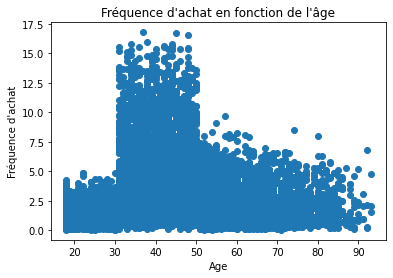

In [57]:
#Affiche la Fréquence d'achat en fonction de l'âge sous forme de nuage de points
plt.scatter(freqs_achat_perage.age, freqs_achat_perage.frequence_achat)
plt.xlabel("Age")
plt.ylabel("Fréquence d'achat")
plt.title("Fréquence d'achat en fonction de l'âge")
plt.show()

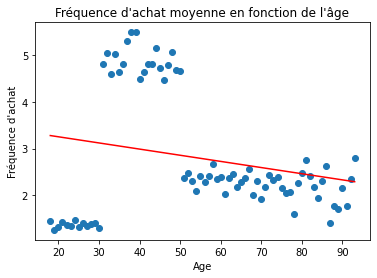

-0.013206865718438572


In [58]:
# Calcule la moyenne de fréquence d'achat par age
freqs_achat_perage2 = freqs_achat_perage.groupby(by="age", as_index=False).mean()
# Calcule la régression linéaire entre fréquence d'achat et age
slope, intercept, r_value, p_value, std_err = st.linregress(freqs_achat_perage2.age, freqs_achat_perage2.frequence_achat)
regression_lineaire = (slope*tachat_perage2.age)+intercept
# Affiche la Fréquence d'achat moyenne en fonction de l'âge sous forme de nuage de points
plt.scatter(freqs_achat_perage2.age, freqs_achat_perage2.frequence_achat)
plt.plot(freqs_achat_perage2.age,regression_lineaire, color="red")
plt.xlabel("Age")
plt.ylabel("Fréquence d'achat")
plt.title("Fréquence d'achat moyenne en fonction de l'âge")
plt.show()
print(slope)

On tente de calculer le coefficient de Pearson.

Hypothèse H0 : Les données ne sont pas corrélées.

In [59]:
#Coefficient de Pearson
st.pearsonr(freqs_achat_perage.age,freqs_achat_perage.frequence_achat)

(0.03044711750546824, 0.00475562829237661)

La pValue est inférieure à 0.05, on peut donc rejeter l'hypothèse H0 et conclure à une corrélation entre les 2 paramètres.

Le coefficient de Pearson présume que les données sont normalement distribuées, hors ici ce n'est pas le cas, on préférera donc l'utilisation du coefficient de Spearman.

Hypothèse H0 : Les données ne sont pas corrélées.

In [60]:
#Coefficient de Spearman
st.spearmanr(tachat_perage.age,tachat_perage.total_achat)

SpearmanrResult(correlation=-0.18513759917564593, pvalue=3.797551375418047e-67)

On obtient une pValue inférieure à 0.05, on rejette donc l'hypothèse H0, les données sont corrélées.

On constate 3 groupes distincts, les moins de 30 ans, les 30-50 ans et les plus de 50 ans, avec une fréquence bien supérieure pour le groupe des 30-50 ans.

## IV.d. Taille du panier moyen par tranches d'age

<function matplotlib.pyplot.show(close=None, block=None)>

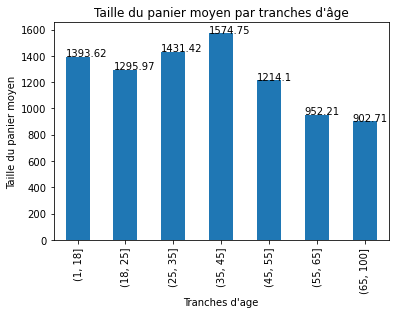

In [61]:
#Etablit la liste des clients actifs
customers_act = pd.merge(customers, transactions, on="client_id", how="inner")
customers_act = customers_act.drop_duplicates(subset=["client_id"], keep="first")
customers_act = customers_act[(customers_act.client_id != "c_3454") & (customers_act.client_id != "c_6714") & (customers_act.client_id != "c_4958") & (customers_act.client_id != "c_1609")]
#Organise la liste des clients actifs par tranche d'age et les comptabilise
customers_act_perage = customers_act.groupby(pd.cut(customers_act.age, age_groups)).count()
# Renomme la colonne client_id en nb_clients
customers_act_perage = customers_act_perage.rename(columns={"client_id" : "nb_clients"})
# Drop les colonnes inutiles
customers_act_perage.drop(customers_act_perage.iloc[:, 1:6], inplace = True, axis = 1)
#Divise la somme du CA de chaque tranche d'age par le nombre de client qui la compose
moy_panier = transactions4_nootl["price"].groupby(pd.cut(transactions4_nootl.age, age_groups)).sum()/customers_act_perage.nb_clients
#Affiche le graphique des données
moy_panier.plot.bar()
plt.xlabel("Tranches d'age")
plt.ylabel("Taille du panier moyen")
plt.title("Taille du panier moyen par tranches d'âge")
#Affiche les données sur le graph
for i in range(7):
  plt.text(-0.25+i, moy_panier.iloc[0+i], str(round(moy_panier.iloc[0+i],2)))
plt.show

In [62]:
# Créé un nouveau dataframe à partir de t4_nootl sans les colonnes qui ne serviront pas ici
panier_par_age = transactions4_nootl.drop(columns=["id_prod","date","session_id", "sex","birth", "age","categ"])
# Regroupe les données par client
panier_par_age = panier_par_age.groupby(by="client_id", as_index=False).sum()
# Rajoute les informations des clients dans le dataframe
panier_par_age = pd.merge(panier_par_age, customers, on="client_id", how="left")
# Drop les colonnes inutiles
panier_par_age = panier_par_age.drop(columns=["sex","birth"])
# Renomme la colone price en panier moyen
panier_par_age = panier_par_age.rename(columns={"price":"panier_moyen"})

In [63]:
#Test de Kolmogorov Smirnov pour tester l'adéquation à une loi normale
x= np.array(panier_par_age["panier_moyen"], dtype=float)
x -= np.mean(x)
x /= np.std(x)
st.kstest(x,'norm')

KstestResult(statistic=0.10643295658178747, pvalue=3.013094422068933e-85)

La Pvalue est inférieure à 0.05 donc on rejette l'hypothèse d'adéquation à une loi normale.

In [64]:
# Créé une table par tranche d'age pour le test de Kruskal
groupe_moins18 = panier_par_age.loc[panier_par_age.age<=18]
groupe18_25 = panier_par_age.loc[(panier_par_age.age>18) & (panier_par_age.age<=25)]
groupe25_35 = panier_par_age.loc[(panier_par_age.age>25) & (panier_par_age.age<=35)]
groupe35_45 = panier_par_age.loc[(panier_par_age.age>35) & (panier_par_age.age<=45)]
groupe45_55 = panier_par_age.loc[(panier_par_age.age>45) & (panier_par_age.age<=55)]
groupe55_65 = panier_par_age.loc[(panier_par_age.age>55) & (panier_par_age.age<=65)]
groupe_65plus = panier_par_age.loc[panier_par_age.age>65]

Pour tester la corrélation entre 1 variable qualitative et une variable quantitative on peut réaliser un test d'Anova.

H0 : Les moyennes des différents groupes sont égales, il n'y a donc pas de corrélation.

In [65]:
# Réalise le test d'Anova
Fstat, pvalue = st.f_oneway(groupe_moins18.panier_moyen, groupe18_25.panier_moyen, groupe25_35.panier_moyen, groupe35_45.panier_moyen, groupe45_55.panier_moyen, groupe55_65.panier_moyen, groupe_65plus.panier_moyen)
print("Pvalue : ", pvalue)
pvalue<=0.05

Pvalue :  4.681514746200481e-113


True

On obtient une pValue inférieur à 0.05, on rejette l'hypothèse H0 et on soupçonne donc une relation entre les variables.

Etant donné que nos 2 jeux de données ne suivent pas une loi normale, on effectue un test de Kruskal à la place du test d'Anova.

Hypothèse H0 : Les médianes de tous les groupes sont proches, il n'y a donc pas de relation entre les variables.

In [66]:
# Réalise le test de Kruskal
Fstat, pvalue = st.kruskal(groupe_moins18.panier_moyen, groupe18_25.panier_moyen, groupe25_35.panier_moyen, groupe35_45.panier_moyen, groupe45_55.panier_moyen, groupe55_65.panier_moyen, groupe_65plus.panier_moyen)
print("Pvalue : ", pvalue)
pvalue<=0.05

Pvalue :  8.106618551113491e-99


True

La Pvalue est inférieure à 0.05 donc on rejette l'hypothèse H0, les médianes de tous les groupes ne sont pas égales, il y a une relation entre les variables.

## IV.e. Catégories de livres achetés par tranches d'age

In [67]:
# Prépare les donnés de catégories par genre en supprimant les colonnes inutiles
categ_par_age = transactions4_nootl.drop(columns=["id_prod","date","session_id", "sex","birth","price"])
# Drop les doublons pour ne garder qu'une seule instance d'un client pour un achat dans une catégorie
categ_par_age = categ_par_age.drop_duplicates(keep="first")
# Créé une table de contingence qui crois les données de sex et d'achat par catégorie
categ_par_age = pd.crosstab(categ_par_age.categ, pd.cut(categ_par_age.age, age_groups), margins=False)
categ_par_age

age,"(1, 18]","(18, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 100]"
categ,,,,,,,
0,313,703,1408,1769,1548,1096,1055
1,427,950,1621,1756,1541,1095,1059
2,415,959,968,403,355,266,227


In [68]:
# Réalise le test du Chi2 pour vérifier si les variables age et catégorie de produit acheté sont indépendantes ou non
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(categ_par_age)
print("Satistique chi2 : ",st_chi2)
print("P value :",st_p)
print("Degrès de liberté :",st_dof)
print("Pvalue<=0.05 :",st_p<=0.05)

Satistique chi2 :  1511.3430629302768
P value : 0.0
Degrès de liberté : 12
Pvalue<=0.05 : True


La Pvalue est inférieur à 0.05 donc on rejette l'hypothèse H0, les variables ne sont pas indépendantes.

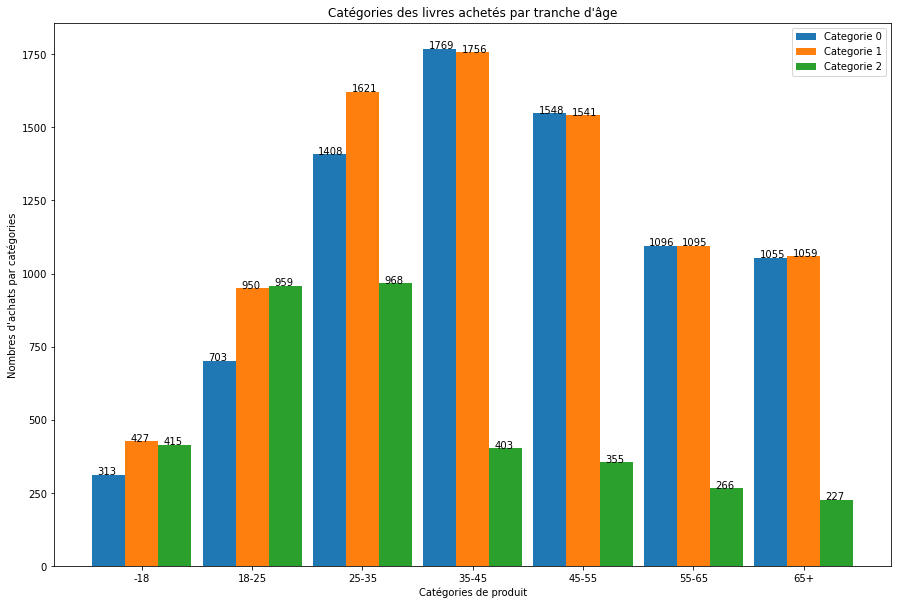

In [69]:
#Nombre de barres
N2 = 7
# Position des barres sur l'axe des abscisses
ind = np.arange(N2)
# Règle la taille de la figure
plt.figure(figsize=(15,10))
# Règle la largeur des barres
width = 0.3
# Créé les barres
c0=plt.bar(ind, categ_par_age.iloc[0] , width, label='Categorie 0')
c1=plt.bar(ind + width, categ_par_age.iloc[1], width, label='Categorie 1')
c2=plt.bar(ind + (width*2), categ_par_age.iloc[2], width, label='Categorie 2')
# Affiche le nom des axes
plt.xlabel('Catégories de produit')
plt.ylabel("Nombres d'achats par catégories")
#Affiche le titre
plt.title("Catégories des livres achetés par tranche d'âge")
# Affiche les noms des ticks de l'axe des abscisses
plt.xticks(ind + (width*2) / 2, ('-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65+'))
# Affiche la légende
plt.legend(loc='best')

tx0=categ_par_age.iloc[0]
tx1=categ_par_age.iloc[1]
tx2=categ_par_age.iloc[2]

#Affiche les valeurs sur le graphique
for i in range(7):
  plt.text(-0.1+i, tx0[0+i], str(tx0[0+i]))
  plt.text(0.2+i, tx1[0+i], str(tx1[0+i]))
  plt.text(0.5+i, tx2[0+i], str(tx2[0+i]))

plt.show()

## IV.f. Probabilité

In [70]:
# Isole les données de transactions pour le produit 2_159
transactions_2159 = transactions.loc[transactions.id_prod=="2_159"]
# Supprime les colonnes inutiles
transactions_2159 = transactions_2159.drop(columns = ["date", "session_id", "id_prod"])
# Supprime les doublons (clients ayant acheté le produit plusieurs fois)
transactions_2159 = transactions_2159.drop_duplicates(keep="first")
# Isole les données de transactions pour le produit 2_159
transactions_0525 = transactions.loc[transactions.id_prod=="0_525"]
# Supprime les colonnes inutiles
transactions_0525 = transactions_0525.drop(columns = ["date", "session_id", "id_prod"])
# Supprime les doublons (clients ayant acheté le produit plusieurs fois)
transactions_0525 = transactions_0525.drop_duplicates(keep="first")
# Effectue une jointure entre les tables pour compter les clients présents dans l'une, l'autre ou les deux tables à la fois
t2159_0525 = pd.merge(transactions_2159, transactions_0525,how="outer", indicator=True)
# Compte les valeurs right only, left only, both
t2159_0525 = t2159_0525._merge.value_counts()
t2159_0525

both          459
left_only      71
right_only      0
Name: _merge, dtype: int64

Parmi les clients qui ont acheté les références 2_159 et/ou 0_525 459 clients ont acheté les deux références, 71 ont acheté la référence 2_159 uniquement et aucun client n'a acheté la référence 0_525 sans la référence 2_159. Donc pAnB est égale à pB.

In [71]:
# Calcule la probabilité qu'un client achète la référence 0_525 si il a acheté la référence 2_159
pA = len(transactions_2159)/len(customers)
pB = len(transactions_0525)/len(customers)
pAnB = pB
pBsachantA = pAnB/pA

print("Il y a ", round(pBsachantA*100,2), "% de chance qu'un client achète la référence 0_525 en sachant qu'il a acheté la référence 2_159.")

Il y a  86.6 % de chance qu'un client achète la référence 0_525 en sachant qu'il a acheté la référence 2_159.
